In [152]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun, hbar
import astropy.units as u
from scipy.optimize import fsolve


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Adimensional 

$$

p'' = \frac{p}{m_f^4} \qquad \epsilon'' = \frac{\epsilon}{m_f^4}  \qquad  M'' =  \frac{M}{a} \qquad R'' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$
$$

p' =p'' \frac{m_f^4}{4B} \qquad \epsilon' = \epsilon''\frac{m_f^4}{4B}
$$

# Quark matter


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

Adimensional 

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$
$$
p' = \frac{1}{3}(\epsilon' - 1)
$$


In [153]:

list_e_1 = np.linspace(1+2e-16, 100, 5000) # adimensional (divided by 4B)
list_p_1= 1/3 * (list_e_1 - 1) # adimensional (divided by 4B)

list_e_quark = list_e_1  # e'
list_p_quark = list_p_1  # p'


In [154]:
import numpy as np

# 1. Define the "excess" energy (delta) directly
# This allows you to go extremely small (e.g., 1e-30) without rounding errors.
# We use geomspace because we are covering many orders of magnitude.
delta_e = np.geomspace(1e-30, 99, 5000) 

# 2. Calculate Pressure directly from delta
# p = 1/3 * (e - 1)  becomes  p = 1/3 * delta_e
list_p_quark = delta_e / 3.0

# 3. Construct total energy for compatibility (if needed)
# WARNING: For the very small values, this will still round to exactly 1.0
list_e_quark = 1.0 + delta_e

The EoS table is independent on the value of B.

In [155]:
# The EoS is independent of the mass scale, so we can work in dimensionless units
def p(z):
    factor = 1 / (24 * np.pi**2)
    term1 = (2*z**3-3*z)
    term2 = (1+z**2)**0.5
    term3 = 3 * np.arcsinh(z)
    return factor * (term1*term2 + term3) # p''

def e(z):
    factor = 1 / (8 * np.pi**2)
    term1 = (2*z**3 + z)
    term2 = (1+z**2)**0.5
    term3 = np.arcsinh(z)
    return factor * (term1*term2 - term3) # e''


# Define a large range of kf to cover the EoS
max_kf = 1e1
min_kf = 9e-4
number_points = int(5e4)

list_kf = np.linspace(min_kf, max_kf, number_points)

list_p_total = np.array(p(list_kf)) 
list_e_total = np.array(e(list_kf))

# Define scale factor to convert dimensionless units 
m_f = 1e5 # MeV
B = 145 ** 4 # MeV^4
scale_factor = m_f**4 / (4 * B)

# Select only the range of energy densities of interest
e_min = 1e-30
e_max = 1e-1
mask = (list_e_total >= e_min) & (list_e_total <= e_max)
list_e_DM = list_e_total[mask] * scale_factor
list_p_DM = list_p_total[mask] * scale_factor







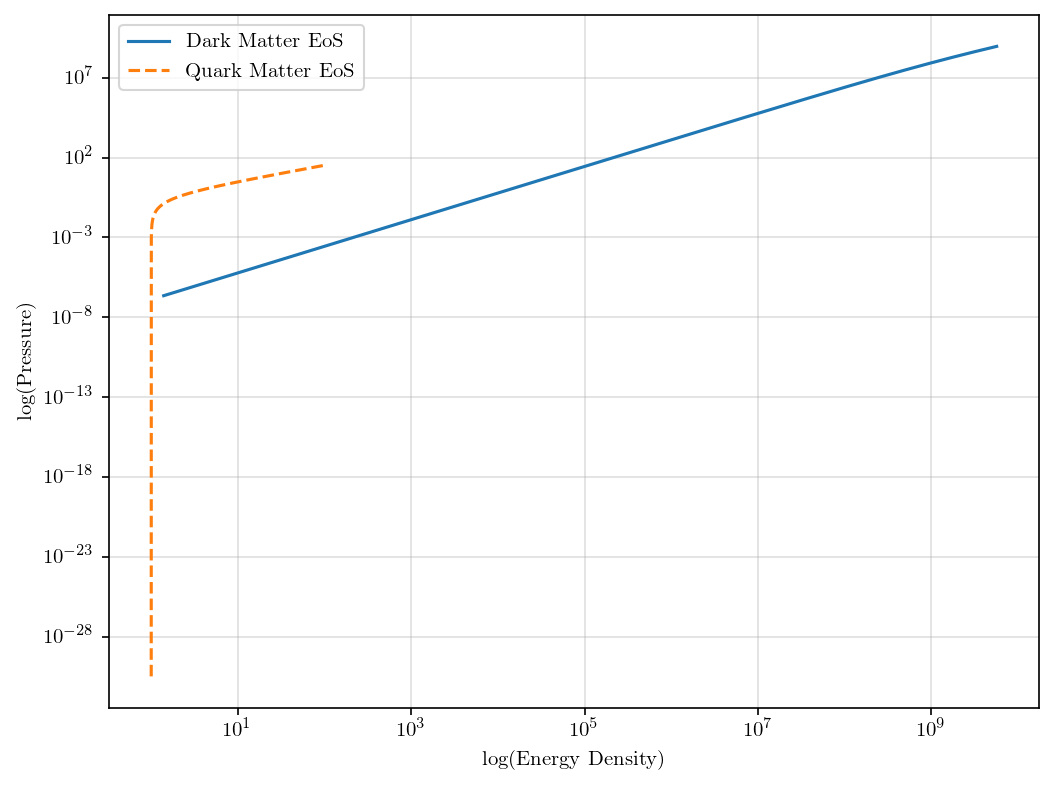

5000 5000
6413 6413
Quark EoS limits:
e_min = 1.00000000e+00
e_max = 1.00000000e+02
p_min = 3.33333333e-31
p_max = 3.30000000e+01

DM EoS limits:
e_min_dm = 1.39243405e+00
e_max_dm = 5.65451948e+09
p_min_dm = 2.25416502e-07
p_max_dm = 9.11269665e+08


In [156]:
# Plot the two EoS

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e_DM, list_p_DM, label ='Dark Matter EoS')
plt.plot(list_e_quark, list_p_quark, linestyle='--', label ='Quark Matter EoS')
plt.xlabel('log(Energy Density)')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e-30, 10)
plt.ylabel('log(Pressure)')
plt.grid()
plt.legend()
plt.show()

print(len(list_e_quark), len(list_p_quark))
print(len(list_e_DM), len(list_p_DM))

#print maximums and minimums of the EoS
print("Quark EoS limits:")
e_min = min(list_e_quark)
e_max = max(list_e_quark)
p_min = min(list_p_quark)
p_max = max(list_p_quark)
print(f"e_min = {e_min:.8e}")
print(f"e_max = {e_max:.8e}")
print(f"p_min = {p_min:.8e}")
print(f"p_max = {p_max:.8e}")
print()

# print maximims and minimums dm
print("DM EoS limits:")
e_min_dm = min(list_e_DM)
e_max_dm = max(list_e_DM)
p_min_dm = min(list_p_DM)
p_max_dm = max(list_p_DM)
print(f"e_min_dm = {e_min_dm:.8e}")
print(f"e_max_dm = {e_max_dm:.8e}")
print(f"p_min_dm = {p_min_dm:.8e}")
print(f"p_max_dm = {p_max_dm:.8e}")

To solved the coupled equations, I need to use the same adimensionalization, otherwhise doesn't have physical sense.

The pressure and density are maximum at the core and go to zero toward the edges. therefore, the maximum values will set the maximum limit i can simulate for central conditions, but what is much more important is the values closer to zero.

The conditions I want to reproduce are:
- DM Central Pressure: $ 3 \times 10^6$ MeV/fm $^3$ 

In [157]:
hc = 197.3269804 # MeV fm

central_pressure_DM_physical = 3e6 * hc**3 #mev /fm^3# 
central_pressure_DM = central_pressure_DM_physical / (4 * B)
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)


print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")


Central pressure DM: 1.30361295e+04
Central energy DM:   4.02277456e+06


DM conditons are $ \sim \times 10^6$ and my EoS goes until $ \sim \times 10^9$. More than enough. 

And in the low limit  $ \sim \times 10^{-7}$

In [176]:
#Initial conditions

r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, list_e_quark, list_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   4.02277456e+06
Central mass DM:     1.68505587e-11


Check that the central conditions are well defined in the EoS

For the selected initial conditions, See what the individuals profiles without interaction will look like

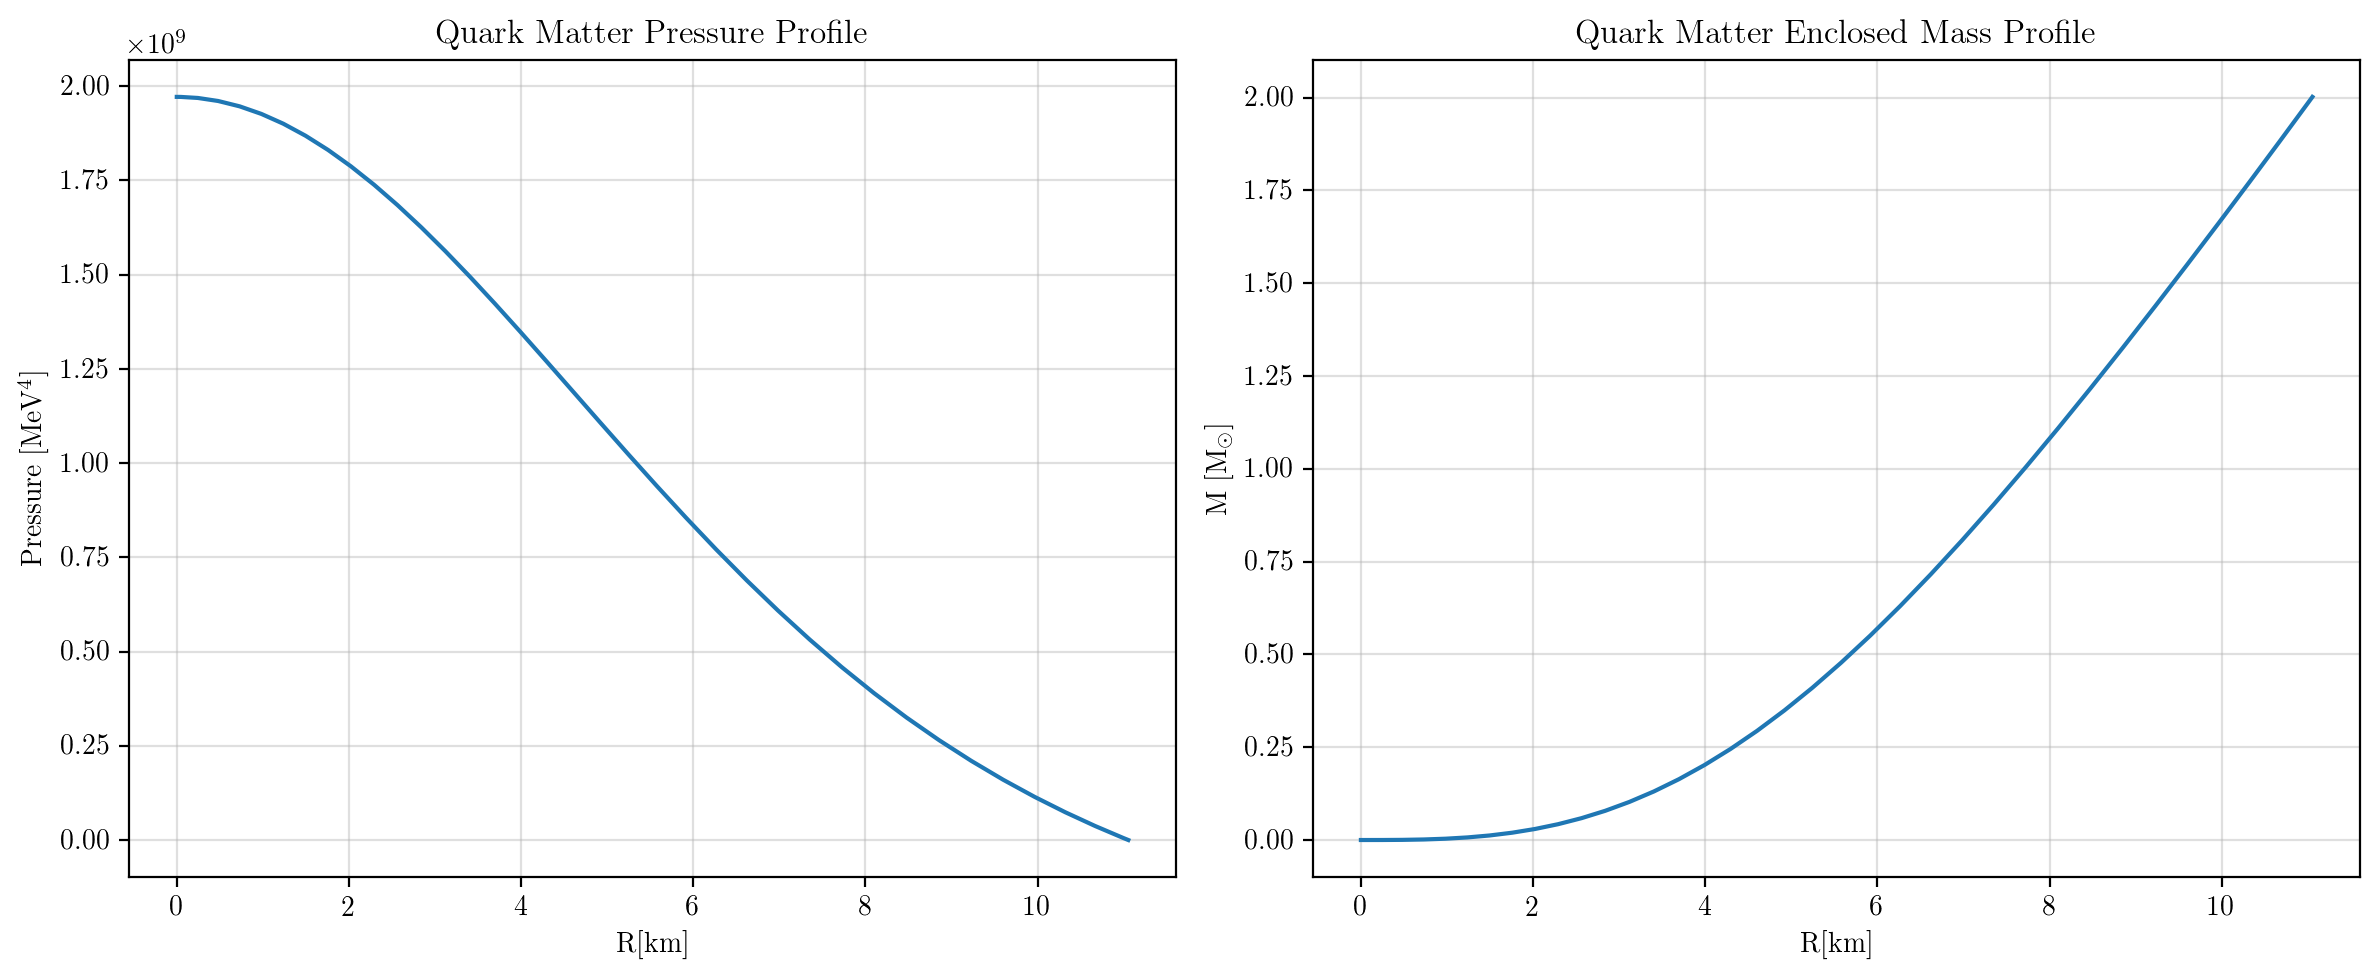

Final Pressure Quark Matter: -6.907819594811096e-08 MeV^4
Raw Final Pressure Quark Matter: -3.9066903224099593e-17


In [164]:

list_e_1_adim = list_e_quark
list_p_1_adim = list_p_quark

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 1e10),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')
    P_profile = sol.y[0]
    M_profile = sol.y[1]
    R_profile = sol.t

    
    return R_surface, M_surface, P_profile, M_profile, R_profile


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


x0_quark = [central_pressure_quark, central_mass_quark]

R_surface, M_surface, P_profile, M_profile, R_profile = solve_TOV(central_energy_quark, x0_quark)




# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

m_planck = np.sqrt((hbar * c) / G) # kg
M_p = (m_planck * c**2).to(u.MeV)
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30


plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))

R_km = R_profile  * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 #km
Mass_mev = M_profile * M_p.value**3 / (2 * np.sqrt(B)) #MeV
Mass_sol = (Mass_mev * mev_to_kg) / msun_kg

plt.plot(R_km , P_profile * (4 * B) )
# recover units

plt.xlabel("R[km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title(" Quark Matter Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(R_km, Mass_sol)
plt.xlabel("R[km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

print(f"Final Pressure Quark Matter: {P_profile[-1] * (4 * B)} MeV^4")
print(f"Raw Final Pressure Quark Matter: {P_profile[-1] }")

In [165]:
list_e = list_e_DM
list_p = list_p_DM
def solve_TOV(central_energy, x0):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, list_p, list_e)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface * (m_f**4), 'MeV^4')
    P_profile = sol.y[0]
    M_profile = sol.y[1]
    R_profile = sol.t

    
    return R_surface, M_surface, P_profile, M_profile, R_profile



# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

x0 = [central_pressure_DM, central_mass_DM]
R_surface, M_surface, P_profile, M_profile, R_profile= solve_TOV(central_energy_DM, x0)

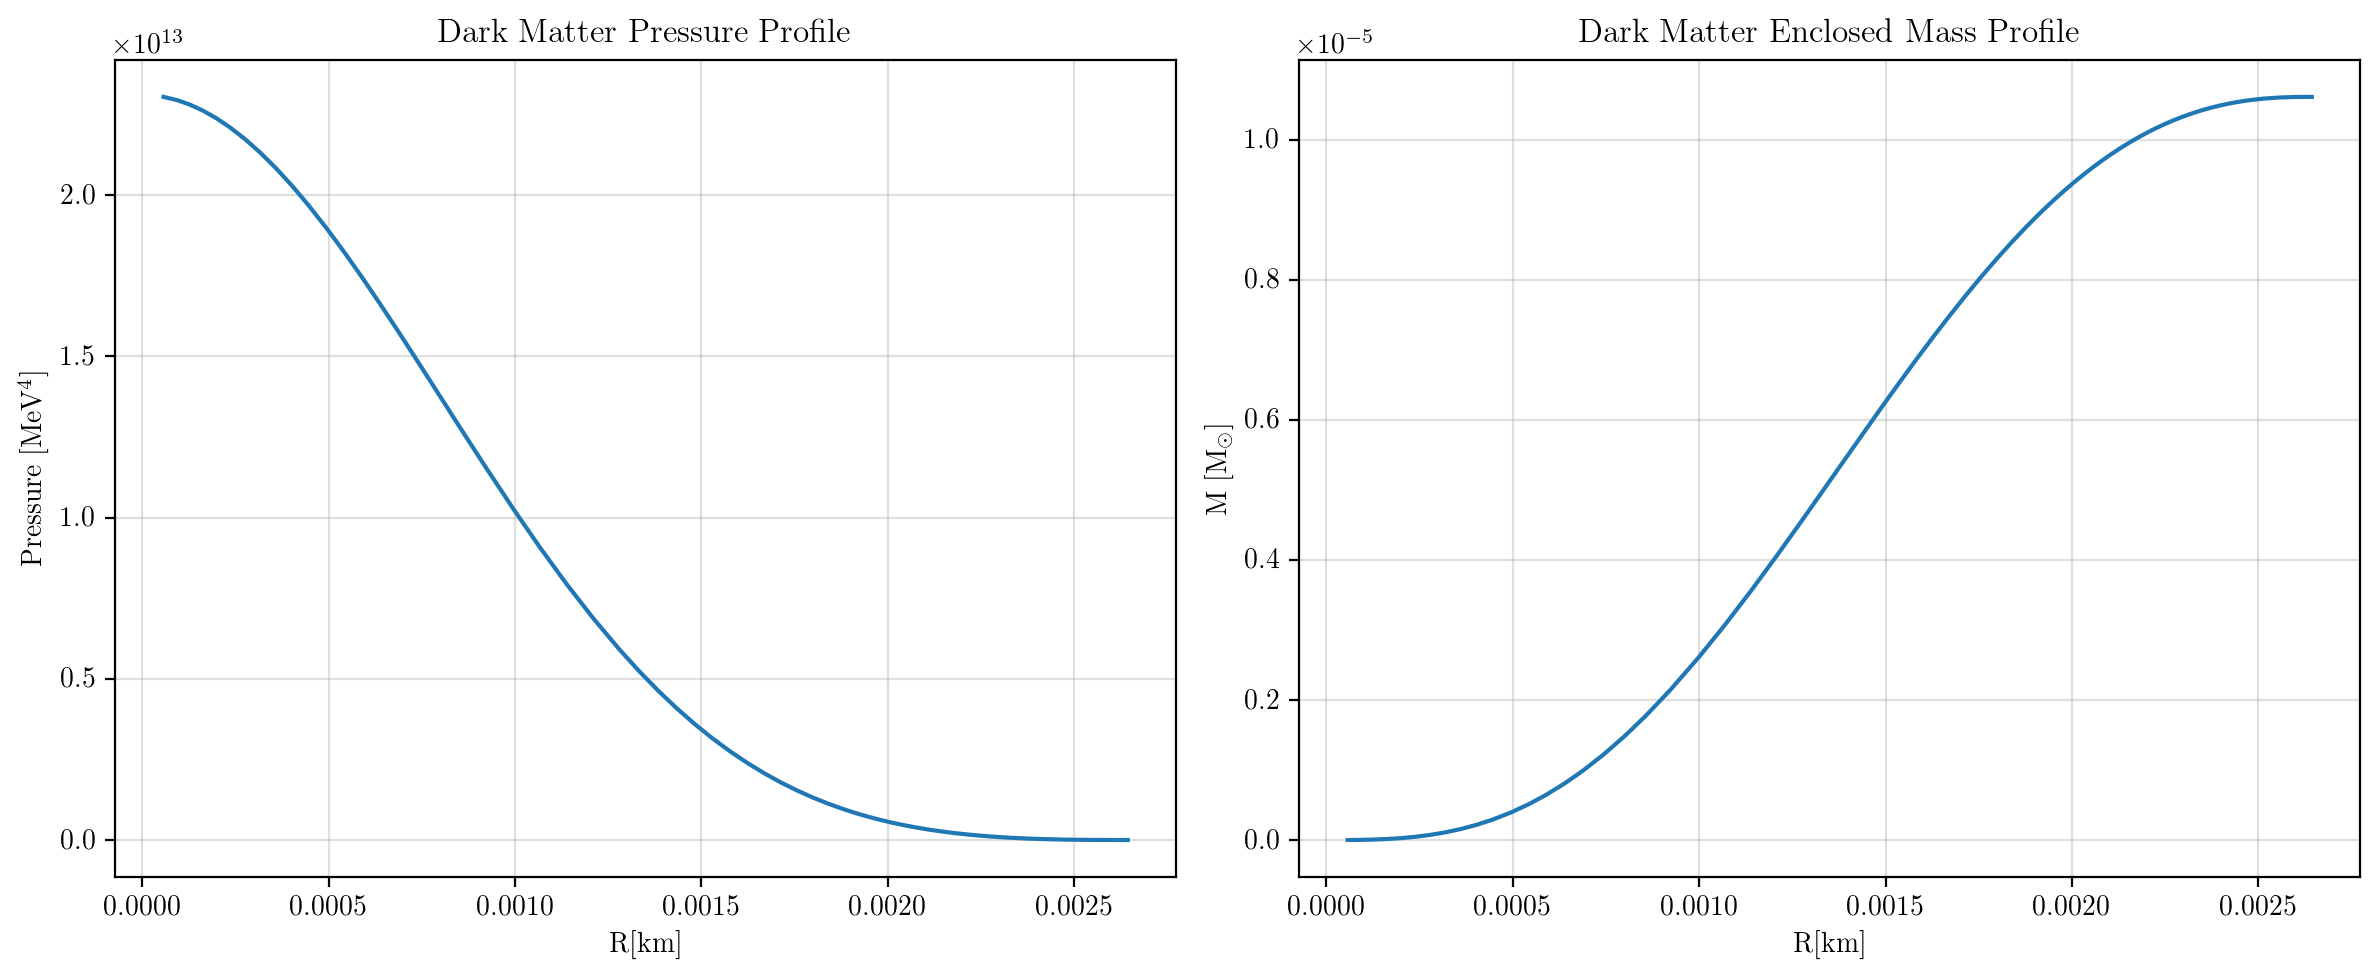

Final Pressure Dark Matter: -3.327143488337354e-05 MeV^4
Raw Final Pressure Quark Matter: 3.2281392178985695e-07


In [166]:

# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

m_planck = np.sqrt((hbar * c) / G) # kg
M_p = (m_planck * c**2).to(u.MeV)
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30


plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))

R_km = R_profile  * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 #km
Mass_mev = M_profile * M_p.value**3 / (2 * np.sqrt(B)) #MeV
Mass_sol = (Mass_mev * mev_to_kg) / msun_kg

plt.plot(R_km , P_profile * (4 * B) )
# recover units

plt.xlabel("R[km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Dark Matter Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(R_km, Mass_sol)
plt.xlabel("R[km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

# final pressure
print(f"Final Pressure Dark Matter: {P_profile[-1] * (4 * B)} MeV^4")
print(f"Raw Final Pressure Quark Matter: {P_profile[-2] }")

Both profiles share the same results in this code that in the individual codes. 

Two fluid

In [170]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    e1 = np.interp(p1, list_p_quark, list_e_quark)
    e2 = np.interp(p2, list_p_DM, list_e_DM) 
    
    M = M1 + M2

    factor = - M * e1 / r**2
    term1 = (1 + p1 / e1)
    term2 = 1 + 4 * np.pi * r**3 * (p1 + p2) / M
    term3 = 1 - 2 * M / r

    if term3 <= 0:
        print("Horizon reached at r =", r)
        print("M =", M)
        print("Term3 =", term3 - 1)
        print("p1 =", p1)
        print("p2 =", p2)
        raise RuntimeError("Horizon reached")

    
    if p1 <= 0.:
        dp1dr = 0.
        dM1dr = 0.
    else:
        dp1dr = factor * term1 * term2 / term3
        dM1dr = 4 * np.pi * r**2 * e1

    if p2 <= 0.:
        dp2dr = 0.
        dM2dr = 0
    else:   
        factor = - M * e2 / r**2
        dp2dr = factor * (1 + p2 / e2) * term2 / term3
        dM2dr = 4 * np.pi * r**2 * e2


    return [dp1dr, dM1dr, dp2dr, dM2dr]

# Because I know that the DM will go zero first, i will stop the integration when the quark matter pressure goes to zero

def quark_surface_event(r, x):
    return x[0]   # Zero-crossing detector

quark_surface_event.terminal = True
quark_surface_event.direction = -1  # Only trigger going from + to -



#Initial conditions


x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------

sol = solve_ivp(
    ode_TOV,
    (r0, 1e12),
    x0,
    events=quark_surface_event,
    max_step=1e-2,
    rtol=1e-8,
    atol=1e-10
)

radius = sol.t
pressure_1 = sol.y[0]
mass_1 = sol.y[1]
pressure_2 = sol.y[2]
mass_2 = sol.y[3]


final_pressure_raw = sol.y[0, -1]
print("Final raw quark pressure:", final_pressure_raw)

final_pressure_raw = sol.y[2, -1]
print("Final raw DM pressure:", final_pressure_raw)


idx_q = np.where(pressure_1 <= p_tol)[0]

if len(idx_q) > 0:
    R_quark = radius[idx_q[0]]
else:
    R_quark = None

idx_dm = np.where(pressure_2 <= p_tol)[0]

if len(idx_dm) > 0:
    R_DM = radius[idx_dm[0]]
else:
    R_DM = None


if R_quark is not None and R_DM is not None:
    if R_quark < R_DM:
        print("Quark pressure goes to zero first")
    elif R_DM < R_quark:
        print("DM pressure goes to zero first")
    else:
        print("Both pressures vanish at the same radius")



print(f"Quark surface radius: {R_quark}")
print(f"DM surface radius:    {R_DM}")
print(f"Final integration radius: {radius[-1]}")

# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

pressure = pressure_1 + pressure_2*0
mass = mass_1 + mass_2*0
plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))
plt.plot(radius, pressure)
plt.xlabel("R")
plt.ylabel("Pressure")
plt.title("QM Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(radius,mass)
plt.xlabel("R")
plt.ylabel("M")
plt.title("QM Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

pressure = pressure_1*0 + pressure_2
mass = mass_1*0 + mass_2
plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))
plt.plot(radius, pressure)
plt.xlabel("R")
plt.ylabel("Pressure")
plt.title("DM Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(radius,mass)
plt.xlabel("R")
plt.ylabel("M")
plt.title("DM Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()


# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

pressure = pressure_1 + pressure_2
mass = mass_1 + mass_2
plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))
plt.plot(radius, pressure)
plt.xlabel("R")
plt.ylabel("Pressure")
plt.title("Two Fluids Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(radius,mass)
plt.xlabel("R")
plt.ylabel("M")
plt.title("Two Fluids Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

#ptol to units
ptol_physical = p_tol * (m_f**4) / hc**3
print("Pressure tolerance in physical units:", ptol_physical, "MeV/fm^3")


Horizon reached at r = 0.0001607880126925409
M = 0.00011916114609090606
Term3 = -1.4822143031118395
p1 = -0.009030915744342853
p2 = -5859736.212730734


RuntimeError: Horizon reached

DM Surface found at R = 4.613887e-05
Quark Surface found at R = 1.939067e-01


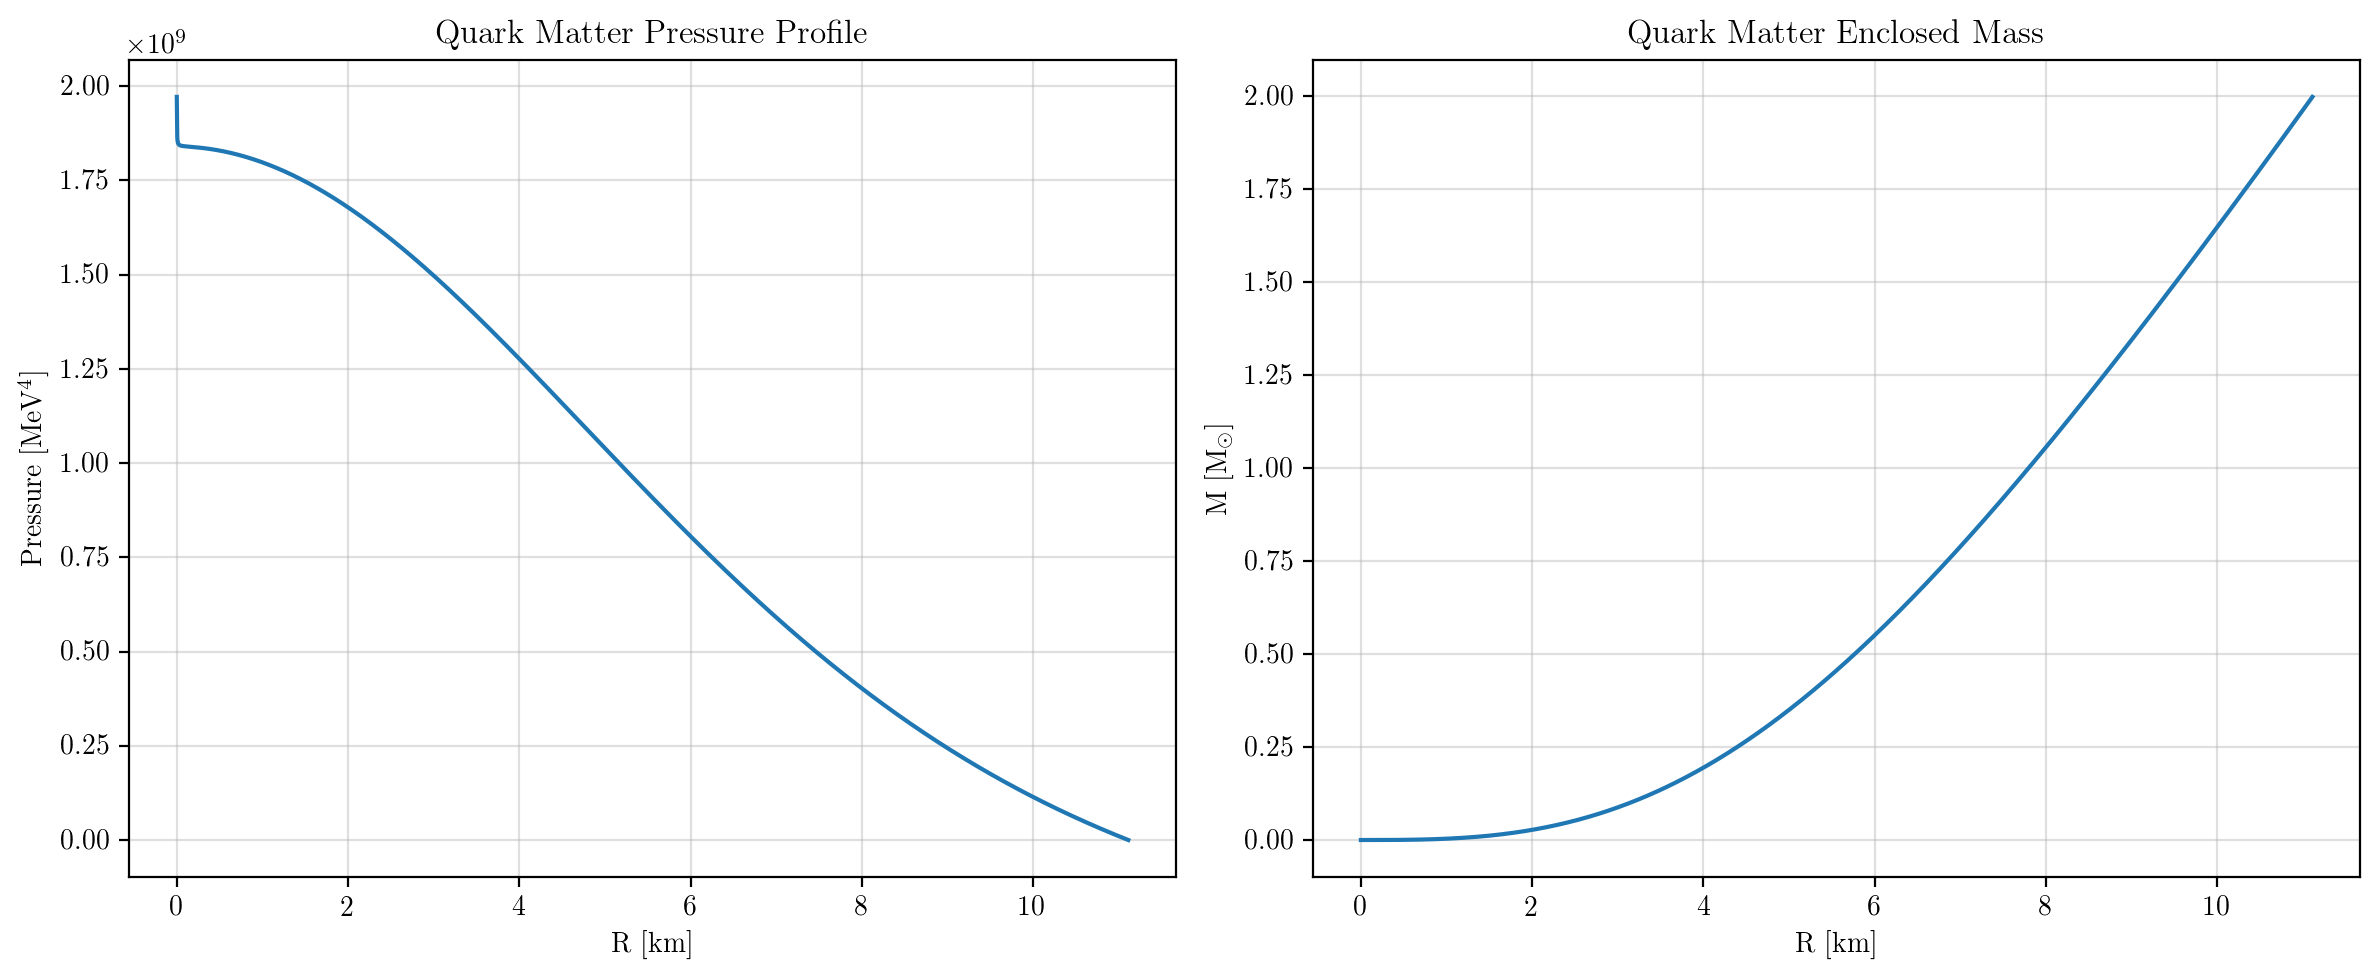

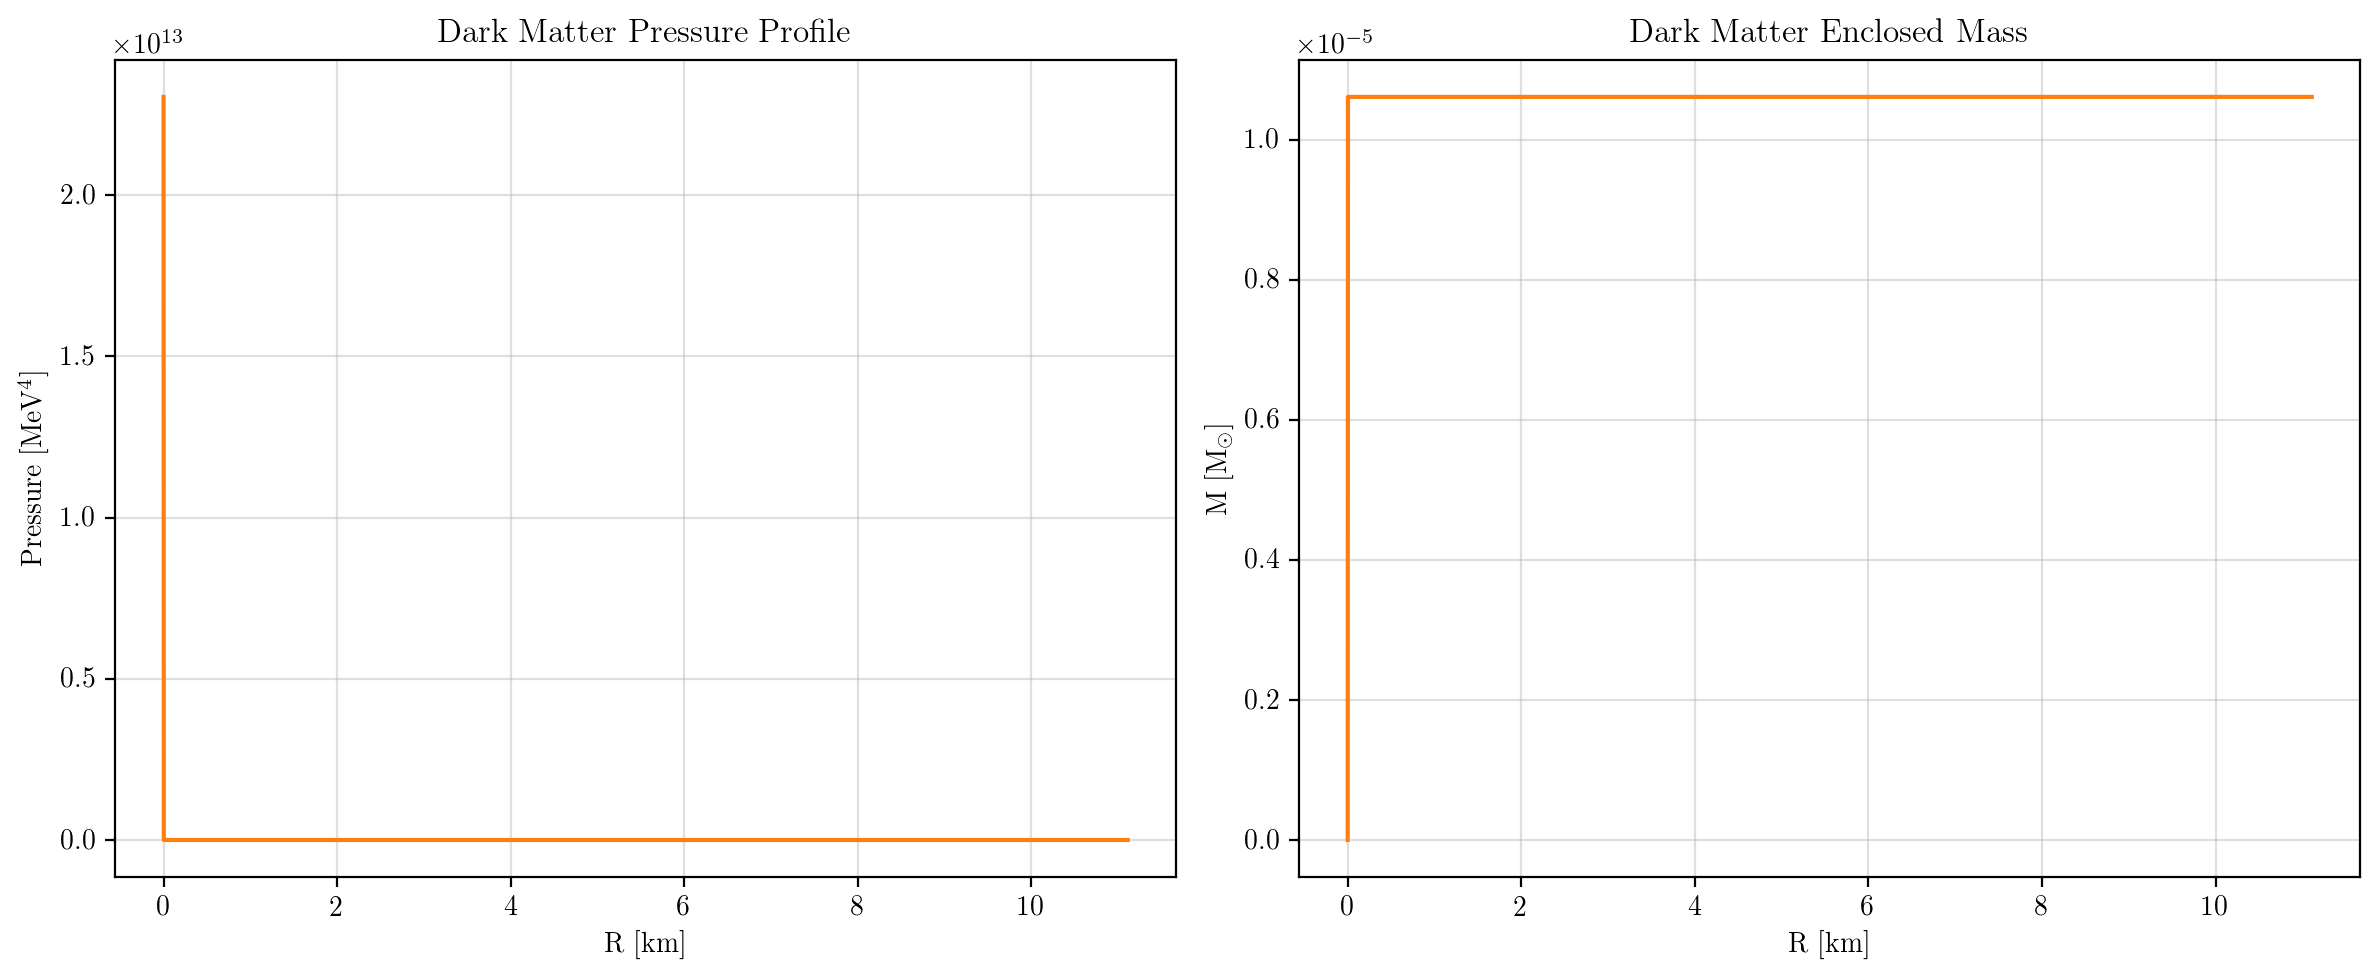

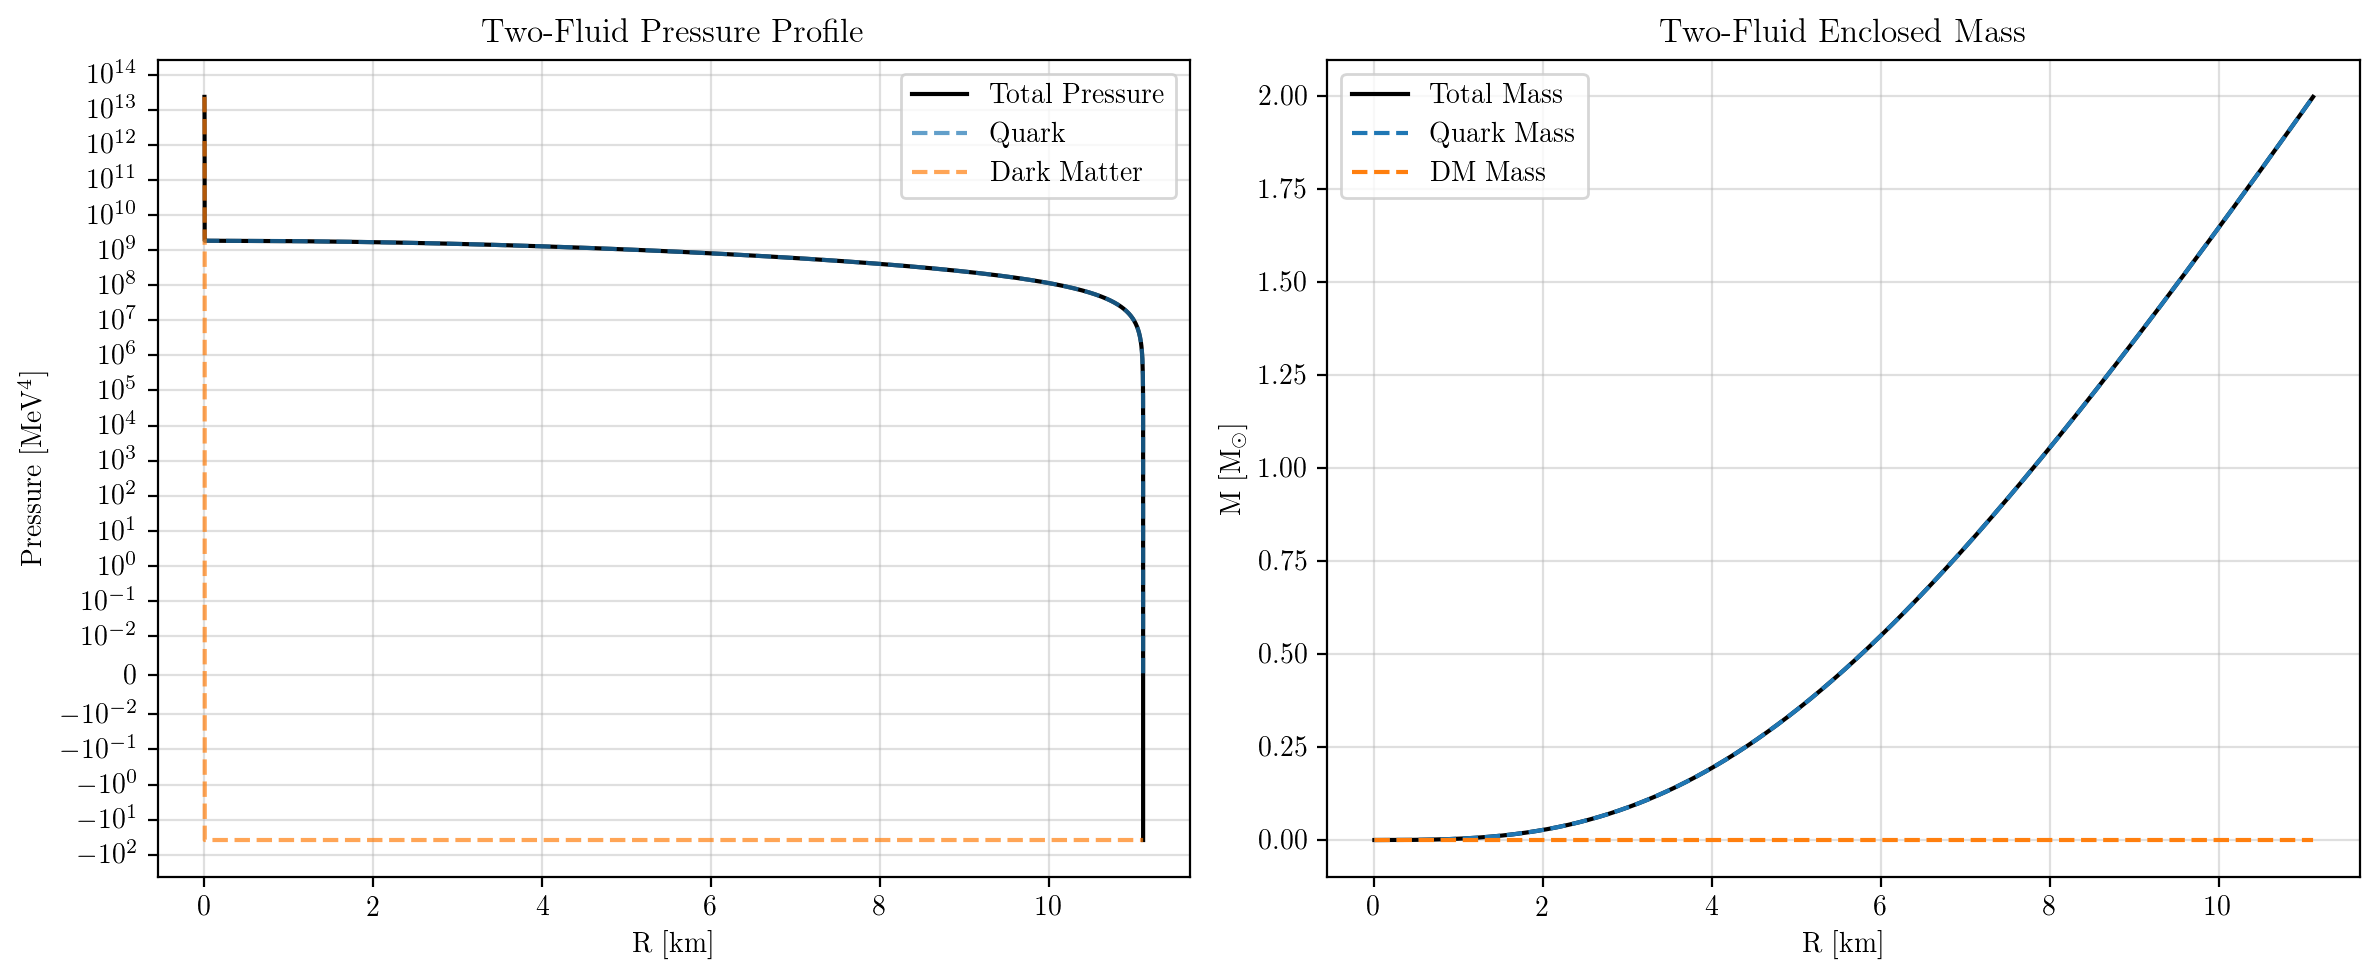

Total Radius: 11.1094 km
Total Mass:   1.9977 Solar Masses


In [180]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    # If pressure is negative (overshoot), treat it as 0 for physics calculations
    p1_phys = max(0.0, p1)
    p2_phys = max(0.0, p2)

    if p1_phys > 0:
        e1 = np.interp(p1_phys, list_p_quark, list_e_quark)
    else:
        e1 = 0.0
        
    if p2_phys > 0:
        e2 = np.interp(p2_phys, list_p_DM, list_e_DM)
    else:
        e2 = 0.0
    
    M = M1 + M2

    # 3. CALCULATE METRIC TERMS (Using clean, physical variables)
    # Protection against r=0 division
    if r < 1e-9:
        dp1dr = 0.0
        dM1dr = 4 * np.pi * r**2 * e1
        dp2dr = 0.0
        dM2dr = 4 * np.pi * r**2 * e2
        return [dp1dr, dM1dr, dp2dr, dM2dr]

    term1_q = (e1 + p1_phys)
    term1_dm = (e2 + p2_phys)
    
    # Use p_phys here! This prevents the negative pressure from breaking gravity
    term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
    term3 = 1 - 2 * M / r

    # Check for Horizon (Just in case, but unlikely with clean vars)
    if term3 <= 1e-9:
        return [0, 0, 0, 0] # or raise error

    # 4. CALCULATE DERIVATIVES
    # Fluid 1 (Quark)
    if p1 <= 0: # Check raw value for stopping condition
        dp1dr = 0.0
        dM1dr = 0.0 
    else:
        factor_1 = - M / r**2 # Standard TOV form G=c=1
        # dp/dr = -(e+p)(M + 4pi*r^3*p)/(r(r-2M))
        # Rearranged: - (M/r^2) * term1 * term2 / term3
        dp1dr = - (M / r**2) * term1_q * term2 / term3
        dM1dr = 4 * np.pi * r**2 * e1

    # Fluid 2 (Dark Matter)
    if p2 <= 0:
        dp2dr = 0.0
        dM2dr = 0.0
    else:
        dp2dr = - (M / r**2) * term1_dm * term2 / term3
        dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]

# ----------------------------------------------------
# 1. Define the Events
# ----------------------------------------------------

def event_DM_surface(r, x):
    p2 = x[2]
    return p2 # The solver looks for when this returns 0
event_DM_surface.terminal = False  # Keep going! Quark matter might extend further.
event_DM_surface.direction = -1    # Only trigger when going from positive to negative.

def event_Quark_surface(r, x):
    p1 = x[0]
    return p1 
event_Quark_surface.terminal = True # Stop the integration. The star ends here.
event_Quark_surface.direction = -1

# ----------------------------------------------------
# 2. Run the Solver
# ----------------------------------------------------
# Pass BOTH events as a list
sol = solve_ivp(
    ode_TOV, 
    (r0, 1e12), 
    x0, 
    events=[event_DM_surface, event_Quark_surface], # List of events
    rtol=1e-8, 
    atol=1e-10,
    max_step=1e-4 # Important for the tiny DM core
)

# ----------------------------------------------------
# 3. Extract the Exact Radii
# ----------------------------------------------------
# sol.t_events is a list of arrays, corresponding to the order of events passed above.
# Index 0 -> DM Surface
# Index 1 -> Quark Surface

# --- Handle Dark Matter Radius ---
if len(sol.t_events[0]) > 0:
    R_DM = sol.t_events[0][0] # The exact interpolated radius
    print(f"DM Surface found at R = {R_DM:.6e}")
else:
    R_DM = None 
    print("DM pressure never reached zero (or is larger than integration limit).")

# --- Handle Quark Matter Radius ---
if len(sol.t_events[1]) > 0:
    R_quark = sol.t_events[1][0] # The exact interpolated radius
    print(f"Quark Surface found at R = {R_quark:.6e}")
else:
    R_quark = None
    print("Quark pressure never reached zero.")


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

# ----------------------------------------------------
# 1. Setup Unit Conversions
# ----------------------------------------------------
# Constants (Assuming these from your previous context)
hbar = const.hbar.to(u.J * u.s).value
c = const.c.to(u.m / u.s).value
G = const.G.to(u.m**3 / (u.kg * u.s**2)).value

hc = 197.3269804  # MeV fm
B = 145**4        # MeV^4 (Bag Constant)

# Planck Mass in MeV
m_planck = np.sqrt((hbar * c) / G) # kg
M_p_MeV = (m_planck * c**2) / (1.60218e-13) # Convert J to MeV manually or use astropy .to(u.MeV).value

# Conversion Factors
# ------------------
# Radius: Adim -> km
# Formula: R_phys = R_adim * (M_p / (2*sqrt(B))) * (hbar*c in MeV*km?? No, careful with units here)
# Your snippet: R_km = R_profile * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 
# Explanation: M_p [MeV] / sqrt(B) [MeV^2] -> [MeV^-1]. * hc [MeV fm] -> [fm]. * 1e-18 -> [km].
factor_R_to_km = (M_p_MeV / (2 * np.sqrt(B))) * hc * 1e-18

# Mass: Adim -> Solar Masses
# Formula: M_phys = M_adim * M_p^3 / (2*sqrt(B))
factor_M_to_MeV = M_p_MeV**3 / (2 * np.sqrt(B))
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30
factor_M_to_Solar = (factor_M_to_MeV * mev_to_kg) / msun_kg

# Pressure: Adim -> MeV^4
factor_P_to_MeV4 = 4 * B

# ----------------------------------------------------
# 2. Apply Conversions to Data
# ----------------------------------------------------
# Extract raw data from solver
r_adim = sol.t
p1_adim = sol.y[0] # Quark
m1_adim = sol.y[1]
p2_adim = sol.y[2] # DM
m2_adim = sol.y[3]

# Convert to Physical Units
R_km = r_adim * factor_R_to_km

P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar

P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar

# ----------------------------------------------------
# 3. Plotting
# ----------------------------------------------------

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure Profile")
plt.grid(True)
# Optional: Use log scale if pressure drops too fast to see
# plt.yscale('symlog', linthresh=1e-5) 

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Enclosed Mass")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Dark Matter Pressure Profile")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Enclosed Mass")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

# Calculate Totals
P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
# Plot total, but maybe dashes for individual components to see the structure
plt.plot(R_km, P_total, label='Total Pressure', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)

plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2) # Highly recommended for 2-fluid due to scale difference!

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark Mass', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM Mass', color='tab:orange')

plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Enclosed Mass")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print Final Physical Values
print(f"Total Radius: {R_km[-1]:.4f} km")
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

the solver was not working at the beginning because my initial pressure and energy conditions for the quark matter where outside the boundaries of the grid of EoS

A flat profile means that the iteration started at a radius very small, inside the swarchild radius. Therefore the denominator is negative, pressure gradients are positive. The solver didnt work and is returning the initial values